# PyGIMLi - DC (Century Deposit Dataset)

Using the ERT (electrical resistivity tomography) solver implemented provided by [PyGIMLi](https://www.pygimli.org/), 
we use different `cofi` solvers to solve problem with a real dataset.

<!--<badge>--><a href="https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/notebooks/pygimli_dcip/pygimli_century_dc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a><!--</badge>-->

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

Note: This notebook is adapted from a SimPEG example authored by Lindsey Heagy and presented at Transform 2020. [Original Materials](https://curvenote.com/@simpeg/transform-2020-simpeg-tutorial/!6DDumb03Le6D8N8xuJNs)

## 1. Set up environment

We'll do the following:
1. Install PyGIMLi (if on CoLab)
2. Download processed dataset (if on CoLab)
3. Import modules

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi

# !pip install -q condacolab
# import condacolab
# condacolab.install()
# !mamba install -c gimli pygimli=1.3

In [2]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd notebooks/pygimli_dcip/

We will need the following packages:

- `os` to list and load dataset
- `numpy` for matrices and matrix-related functions
- `matplotlib` for plotting
- `pygimli` for forward modelling of the problem
- `cofi` for accessing different inference solvers

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pygimli
import cofi

## 2. Load the data

We will need to download the preprocessed dataset first. This notebook [century_data_preprocessing.ipynb](century_data_preprocessing.ipynb) contains the code for data preprocessing.

In [4]:
dcip_data = np.loadtxt("century_dcip_data.txt")

In [5]:
a_locs = dcip_data[:,0]
b_locs = dcip_data[:,1]
m_locs = dcip_data[:,2]
n_locs = dcip_data[:,3]
dc_obs = dcip_data[:,4]
dc_err = dcip_data[:,5]
geo_factors = dcip_data[:,8]

location_start = np.min(a_locs)
location_stop = np.max(n_locs)
location_interval = m_locs[1] - m_locs[0]
location_num = int((location_stop - location_start) / location_interval + 1)

location_start, location_stop, location_interval, location_num

(26000.0, 29200.0, 100.0, 33)

In [6]:
def load_leapfrog_geologic_section(filename="century_geologic_section.csv"):
    """
    Load the geologic cross section. 
    """
    fid = open(filename, 'r')
    lines = fid.readlines()
    data = []
    data_tmp = []
    for line in lines[2:]:
        line_data = (line.split(',')[:3])
        if 'End' in line:
            data.append(np.vstack(data_tmp)[:,[0, 2]])
            data_tmp = []
        else:
            data_tmp.append(np.array(line_data, dtype=float))
    return data

geologic_section = load_leapfrog_geologic_section()

## 3. Utility wrappers to PyGIMLi functions

### 3.1. Data container, mesh and forward operator

In [7]:
# inversion mesh bound
x_inv_start = location_start - 1000
x_inv_stop = location_stop + 1000
y_inv_start = -400
y_inv_stop = 0
x_gridmesh = np.linspace(start=x_inv_start, stop=x_inv_stop, num=40)
y_gridmesh = np.linspace(start=y_inv_start, stop=y_inv_stop, num=10)

# PyGIMLi DataContainerERT
def pygimli_data(a_locs, b_locs, m_locs, n_locs, dc_obs, dc_err):
    # --- create empty data container object ---
    data = pygimli.DataContainerERT()
    # create sensor locations
    for sensor in np.linspace(location_start, location_stop, location_num):
        data.createSensor((sensor, 0.0, 0.0))
    # --- add indices for data points ---
    locs_sources = np.vstack((a_locs, b_locs)).T
    locs_receivers = np.vstack((m_locs, n_locs)).T
    for i in range(len(locs_sources)):
        src = locs_sources[i]
        src_idx = (src - location_start) / location_interval
        rec = locs_receivers[i]
        rec_idx = (rec - location_start) / location_interval
        data.createFourPointData(i, src_idx[0], src_idx[1], rec_idx[0], rec_idx[1])
    # --- fill in the observed data and error estimation ---
    data["rhoa"] = dc_obs
    data["err"] = dc_err
    # --- create geometric factor k ---
    data["k"] = pygimli.physics.ert.createGeometricFactors(data, numerical=True)
    # --- generate data covariance inv matrix in log space ---
    log_data_cov_inv = np.diag(1/np.log(data["err"])**2)
    return data, np.log(dc_obs), log_data_cov_inv

# PyGIMLi ert.ERTManager
def ert_manager(data, verbose=False):
    return pygimli.physics.ert.ERTManager(data, verbose=verbose, useBert=True)

# inversion mesh
def inversion_mesh(ert_mgr):
    inv_mesh = ert_mgr.createMesh(ert_mgr.data)
    inv_mesh = inv_mesh.createH2()
    ert_mgr.setMesh(inv_mesh)
    return inv_mesh

# inversion mesh that SimPEG uses
def inversion_mesh_simpeg():
    # calculate dimension in x and z directions
    n_cells_per_spacing = 4
    dx = location_interval / n_cells_per_spacing
    dz = dx
    # calculate x range
    x_range = (location_start, location_stop)
    # calculate z range
    ab_midpoints = (a_locs + b_locs) / 2
    mn_midpoints = (m_locs + n_locs) / 2
    ab_mn_separation = np.abs(ab_midpoints - mn_midpoints)
    max_separation = np.max(ab_mn_separation)
    z_depth = - max_separation / 3.
    z_range = (z_depth, 0.)
    # print
    print(f"Mesh dimension: ({dx}, {dz})")
    print(f"Mesh range x: {x_range}")
    print(f"Mesh range z: {z_range}")
    # params for creating mesh nodes
    n_midd_extra = 4
    n_midd_x = np.ceil(np.diff(x_range)/dx) + n_midd_extra*2
    n_top_z = np.ceil(np.diff(z_range)/dz) + n_midd_extra
    n_side = 10         # number of nodes extending in x and z
    extending_factor = 1.3
    extending_list = (np.ones(n_side) * extending_factor) ** (np.arange(n_side) + 1)
    # create nodes in x direction
    dist_x_left = (extending_list * dx)[::-1]
    dist_x_midd = int(n_midd_x) * [dx]
    dist_x_right = extending_list * dx
    dist_x = np.hstack((dist_x_left, dist_x_midd, dist_x_right))
    nodes_x = np.r_[(x_range[1]+x_range[0])/2-np.sum(dist_x)/2, dist_x].cumsum()
    # create nodes in z direction
    dist_z_bot = (extending_list * dz)[::-1]
    dist_z_top = int(n_top_z) * [dz]
    dist_z = np.hstack((dist_z_bot, dist_z_top))
    nodes_z = np.r_[-np.sum(dist_z), dist_z].cumsum()
    # create mesh
    inv_mesh = pygimli.meshtools.createGrid(x=nodes_x, y=nodes_z)
    return inv_mesh

# PyGIMLi ert.ERTModelling
def ert_forward_operator(ert_mgr, data_scheme, inv_mesh):
    forward_operator = ert_mgr.fop
    forward_operator.setComplex(False)
    forward_operator.setData(data_scheme)
    forward_operator.setMesh(inv_mesh, ignoreRegionManager=True)
    return forward_operator

# regularization matrix
def reg_matrix(forward_oprt):
    region_manager = forward_oprt.regionManager()
    region_manager.setConstraintType(2)
    Wm = pygimli.matrix.SparseMapMatrix()
    region_manager.fillConstraints(Wm)
    Wm = pygimli.utils.sparseMatrix2coo(Wm)
    return Wm

# initialise model
def starting_model(ert_mgr, val=None):
    data = ert_mgr.data
    start_val = val if val else np.median(data['rhoa'].array())     # this is how pygimli initialises
    start_model = np.ones(ert_mgr.paraDomain.cellCount()) * start_val
    start_val_log = np.log(start_val)
    start_model_log = np.ones(ert_mgr.paraDomain.cellCount()) * start_val_log
    return start_model, start_model_log

### 3.2. Plotting utilities

*Colorbars are plotted separately for compatibility to Colab mpl version.

In [8]:
# plot colorbar for data
def colorbar(ax, cMin, cMax, label, orientation="horizontal"):
    norm = mpl.colors.Normalize(cMin, cMax)
    sm = plt.cm.ScalarMappable(norm=norm)
    cb = plt.colorbar(sm, orientation=orientation, ax=ax)
    cb.set_label(label)
    cb.set_ticks(np.arange(cMin, cMax+0.1, (cMax-cMin)/5))

def plot_data(data, data_vals, title, ax=None, cMin=None, cMax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    if cMin is None:
        pygimli.physics.ert.showERTData(
            data, 
            vals=data_vals, 
            label=r"$\Omega$m", 
            ax=ax, 
            colorBar=False,
        )
        colorbar(ax, min(data_vals), max(data_vals), r'$\Omega \mathrm{m}$')
    else:
        pygimli.physics.ert.showERTData(
            data, 
            vals=data_vals, 
            label=r"$\Omega$m", 
            ax=ax, 
            cMin=cMin,
            cMax=cMax,
            colorBar=False,
        )
        colorbar(ax, cMin, cMax, r'$\Omega \mathrm{m}$')
    ax.set_xlabel("Horizontal Distance (m)")
    ax.set_ylabel("Dipole Dipole Separation (m)")
    ax.set_title(title)
    
def plot_mesh(mesh, title="Mesh used for inversion"):
    _, ax = plt.subplots(1, 1)
    pygimli.show(mesh, showMesh=True, markers=True, colorBar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel("Northing (m)")
    ax.set_ylabel("Elevation (m)")
    
def plot_model(mesh, model, title, initial_model=True, ax=None):
    if ax is None:
        _, ax = plt.subplots(1, 1)
    pygimli.show(mesh, data=model, ax=ax, label=r"$\Omega m$", colorBar=False)
    ax.set_xlabel("Horizontal Distance (m)")
    ax.set_ylabel("Elevation (m)")
    ax.set_title(title)
    cmin = model[0] if initial_model else min(model)
    cmax = model[0] + 20 if initial_model else max(model)
    colorbar(ax, cmin, cmax, r"$\Omega$m")

def plot_result(inv_result, ert_mgr, title=None):
    # convert back to normal space from log space
    model = np.exp(inv_result.model)
    # add title
    fig, ax = plt.subplots(1, 1, figsize=(10,7))
    if title is not None:
        fig.suptitle(title, fontsize=16)
    # plot inferred model
    plot_model(ert_mgr.paraDomain, model, "Inferred model", False, ax)
    ax.set_ylim(y_inv_start, y_inv_stop)
    # plot the data
    _, axes = plt.subplots(1, 2, figsize=(12,4))
    # plot synthetic data
    d_scheme = ert_mgr.data
    dobs = d_scheme["rhoa"]
    d = forward_oprt.response(model)
    plot_data(d_scheme, data_vals=d, title="Synthetic data", ax=axes[0], cMin=min(dobs), cMax=max(dobs))
    # plot observed data
    plot_data(d_scheme, data_vals=dobs, title="Observed data", ax=axes[1])

def plot_comparison(mesh1, model1, title1, mesh2, model2, title2, color_range):
    fig, axes = plt.subplots(2, 1, figsize=(10,6))
    pygimli.show(
        mesh1, 
        data=model1,
        ax=axes[0],
        label=r"$\Omega m$", 
        cMin=color_range[0],
        cMax=color_range[1],
        colorBar=False
    )
    axes[0].set_xlabel("Horizontal Distance (m)")
    axes[0].set_ylabel("Elevation (m)")
    axes[0].set_xlim(mesh2.xMin(), mesh2.xMax())
    axes[0].set_ylim(y_inv_start, y_inv_stop)
    axes[0].set_title(title1)
    pygimli.show(
        mesh2, 
        data=model2,
        ax=axes[1],
        label=r"$\Omega m$", 
        cMin=color_range[0],
        cMax=color_range[1],
        colorBar=False
    )
    axes[1].set_xlabel("Horizontal Distance (m)")
    axes[1].set_ylabel("Elevation (m)")
    axes[1].set_ylim(y_inv_start, y_inv_stop)
    axes[1].set_title(title2)
    colorbar(axes, color_range[0], color_range[1], r"$\Omega$m")

## 4. PyGIMLi problem setup

### 4.1. Data container

In [9]:
data, log_data_vals, log_data_cov_inv = pygimli_data(a_locs, b_locs, m_locs, n_locs, dc_obs, dc_err)
data

15/11/22 - 14:05:13 - pyGIMLi - INFO - Cache /home/jiawen/opt/mambaforge/envs/cofi_env/lib/python3.10/site-packages/pygimli/physics/ert/ert.py:createGeometricFactors restored (3.2s x 35): /home/jiawen/.cache/pygimli/17361711778874842652


Data: Sensors: 33 data: 151, nonzero entries: ['a', 'b', 'err', 'k', 'm', 'n', 'rhoa', 'valid']

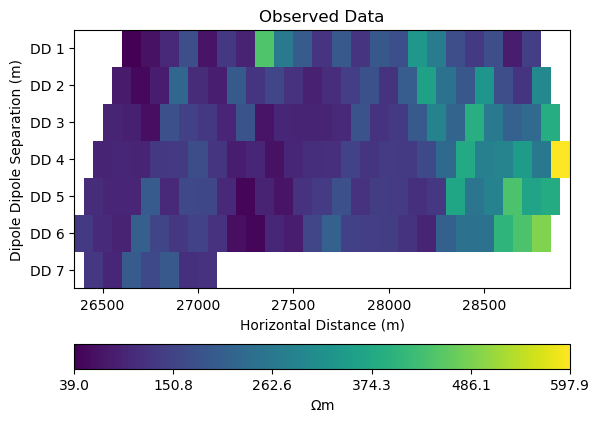

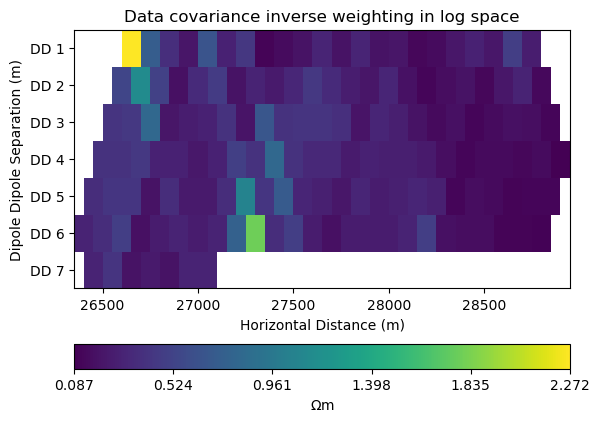

In [10]:
plot_data(data, data["rhoa"], "Observed Data")
# plot_data(data, data["err"], "Observed Data Error")
plot_data(data, np.diag(log_data_cov_inv), "Data covariance inverse weighting in log space")

### 4.2. ERT manager

In [11]:
ert_mgr = ert_manager(data)

### 4.3. Inversion mesh

In [12]:
# inv_mesh = inversion_mesh_simpeg()
inv_mesh = inversion_mesh(ert_mgr)

15/11/22 - 14:05:14 - pyGIMLi - INFO - Found 2 regions.
15/11/22 - 14:05:14 - pyGIMLi - INFO - Region with smallest marker (1) set to background


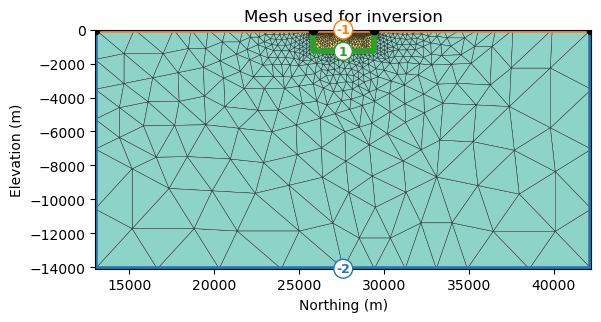

In [13]:
plot_mesh(inv_mesh)

### 4.4. Forward operator

In [14]:
forward_oprt = ert_forward_operator(ert_mgr, data, inv_mesh)

### 4.5. Regularization matrix

In [15]:
Wm = reg_matrix(forward_oprt)

15/11/22 - 14:05:14 - Core - WARNING - Region Nr: 1  is background and should not get a model transformation.
15/11/22 - 14:05:14 - Core - WARNING - Region Nr: 1  is background and should not get a model control.


### 4.6. Starting model

15/11/22 - 14:05:14 - pyGIMLi - INFO - Creating forward mesh from region infos.
15/11/22 - 14:05:14 - pyGIMLi - INFO - Creating refined mesh (H2) to solve forward task.


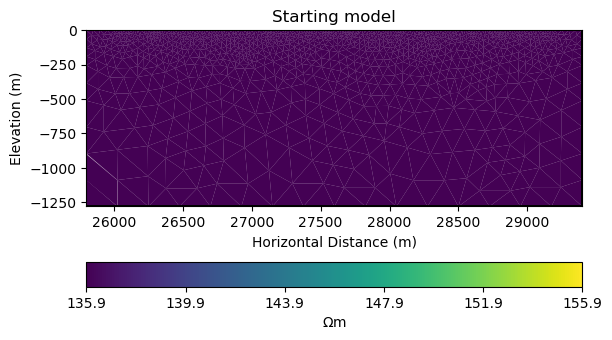

In [16]:
start_model, start_model_log = starting_model(ert_mgr)

plot_model(ert_mgr.paraDomain, start_model, "Starting model")

## 5. Create utility functions to pass to CoFI

In [17]:
#@title additional utility functions (hidden)
############# Functions provided to CoFI ##############################################

## Note: all functions below assume the model in log space!

def _ensure_numpy(model):
    if "torch.Tensor" in str(type(model)):
        model = model.cpu().detach().numpy()
    return model

def get_response(model, forward_operator):
    model = _ensure_numpy(model)
    return np.log(np.array(forward_operator.response(np.exp(model))))

def get_residual(model, log_data, forward_operator):
    response = get_response(model, forward_operator)
    residual = log_data - response
    return residual

def get_jacobian(model, forward_operator):
    response = get_response(model, forward_operator)
    model = _ensure_numpy(model)
    forward_operator.createJacobian(np.exp(model))
    J = np.array(forward_operator.jacobian())
    jac = J / np.exp(response[:, np.newaxis]) * np.exp(model)[np.newaxis, :]
    return jac

def get_jac_residual(model, log_data, forward_operator):
    response = get_response(model, forward_operator)
    residual = log_data - response
    model = _ensure_numpy(model)
    forward_operator.createJacobian(np.exp(model))
    J = np.array(forward_operator.jacobian())
    jac = J / np.exp(response[:, np.newaxis]) * np.exp(model)[np.newaxis, :]
    return jac, residual

def get_data_misfit(model, log_data, forward_operator, data_cov_inv=None):
    residual = get_residual(model, log_data, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    return np.abs(residual.T @ data_cov_inv @ residual)

def get_regularization(model, Wm, lamda):
    model = _ensure_numpy(model)
    model = np.exp(model)
    return lamda * (Wm @ model).T @ (Wm @ model)

def get_objective(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    data_misfit = get_data_misfit(model, log_data, forward_operator, data_cov_inv)
    regularization = get_regularization(model, Wm, lamda)
    obj = data_misfit + regularization
    return obj

def get_gradient(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    jac, residual = get_jac_residual(model, log_data, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    data_misfit_grad =  - residual.T @ data_cov_inv @ jac
    regularization_grad = lamda * Wm.T @ Wm @ np.exp(model)
    return data_misfit_grad + regularization_grad

def get_hessian(model, log_data, forward_operator, Wm, lamda, data_cov_inv=None):
    jac = get_jacobian(model, forward_operator)
    data_cov_inv = np.eye(log_data.shape[0]) if data_cov_inv is None else data_cov_inv
    hess = jac.T @ data_cov_inv @ jac + lamda * Wm.T @ Wm
    return hess

In [18]:
# test
get_response(start_model_log, forward_oprt)

array([4.91193578, 4.91192554, 4.91195823, 4.91193258, 4.91196008,
       4.91199414, 4.91194026, 4.91196934, 4.91193526, 4.91198051,
       4.91190346, 4.91195229, 4.91191395, 4.91196424, 4.91202556,
       4.91185204, 4.91194679, 4.91190529, 4.91197692, 4.91194506,
       4.91275931, 4.91168961, 4.91192017, 4.91189355, 4.91200432,
       4.91195118, 4.91194765, 4.91043787, 4.91174258, 4.91183852,
       4.91204985, 4.91196258, 4.91195319, 4.91197764, 4.91374488,
       4.91205065, 4.91224037, 4.91202417, 4.91198312, 4.91200452,
       4.91316566, 4.91252703, 4.91201697, 4.91196104, 4.91199733,
       4.91198766, 4.91605466, 4.91222609, 4.9120111 , 4.91204798,
       4.91202551, 4.91195884, 4.91089316, 4.9115291 , 4.91184107,
       4.91191696, 4.91186748, 4.91190861, 4.91151932, 4.91200603,
       4.91206454, 4.91194044, 4.91197406, 4.91201106, 4.91328356,
       4.91228745, 4.91196221, 4.91199841, 4.91203752, 4.91199142,
       4.91283699, 4.91170012, 4.91188719, 4.91198705, 4.91194

## 6. Run inversion with CoFI

### 6.1. Simple Newton

In [19]:
# hyperparameters
lamda = 0.00001

# CoFI - define BaseProblem
ert_problem = cofi.BaseProblem()
ert_problem.name = "Electrical Resistivity Tomography with Century Dataset"
ert_problem.set_data_misfit(get_data_misfit, args=[log_data_vals, forward_oprt, log_data_cov_inv])
ert_problem.set_regularization(get_regularization, args=[Wm, lamda])
ert_problem.set_gradient(get_gradient, args=[log_data_vals, forward_oprt, Wm, lamda, log_data_cov_inv])
ert_problem.set_hessian(get_hessian, args=[log_data_vals, forward_oprt, Wm, lamda, log_data_cov_inv])
ert_problem.set_initial_model(start_model_log)

In [20]:
# test
ert_problem.data_misfit(start_model_log), ert_problem.regularization(start_model_log)

(16.597655174229914, 3.1576650531931535e-29)

In [21]:
# CoFI - define InversionOptions
inv_options = cofi.InversionOptions()
inv_options.set_tool("cofi.simple_newton")
inv_options.set_params(max_iterations=60, step_length=0.01)

# CoFI - define Inversion and run
inv = cofi.Inversion(ert_problem, inv_options)
inv_result = inv.run()

print(f"\nNumber of objective function evaluations: {inv_result.n_obj_evaluations}")
print(f"Number of gradient function evaluations: {inv_result.n_grad_evaluations}")
print(f"Number of hessian function evaluations: {inv_result.n_hess_evaluations}")

Iteration #0, objective function value: 16.597655174229914
Iteration #1, objective function value: 16.267952266246922
Iteration #2, objective function value: 15.947594157939143
Iteration #3, objective function value: 15.635057380202147
Iteration #4, objective function value: 15.32992470249226
Iteration #5, objective function value: 15.032071589869176
Iteration #6, objective function value: 14.741303283801818
Iteration #7, objective function value: 14.457462673748035
Iteration #8, objective function value: 14.180392430120492
Iteration #9, objective function value: 13.909944524112888
Iteration #10, objective function value: 13.645975984843652
Iteration #11, objective function value: 13.388348389479516
Iteration #12, objective function value: 13.136927175433714
Iteration #13, objective function value: 12.891580246645287
Iteration #14, objective function value: 12.652179252826127
Iteration #15, objective function value: 12.418597532153374
Iteration #16, objective function value: 12.1907109

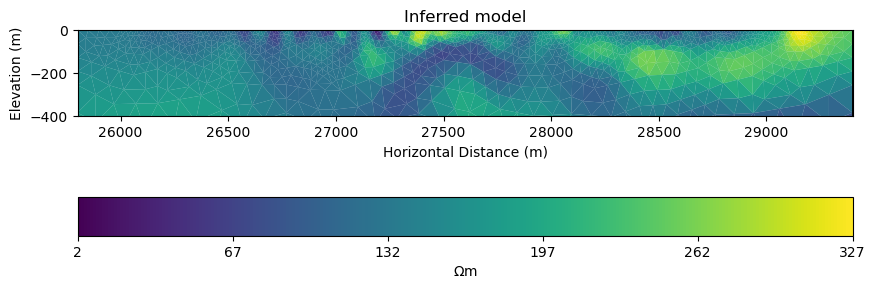

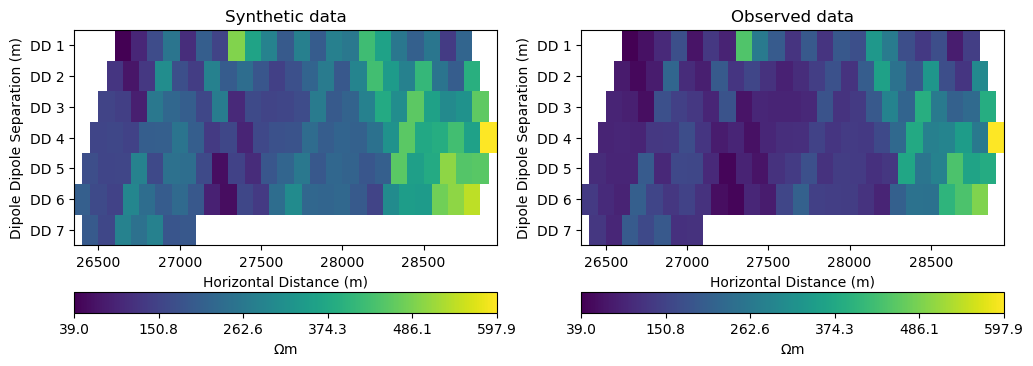

In [22]:
plot_result(inv_result, ert_mgr)

#### 6.1.1 Compare with UBC results

In [23]:
import meshio

mesh_ubc = pygimli.meshtools.readMeshIO("century_mesh.vtk")
model_ubc = np.loadtxt("century_dc_model.txt")

In [24]:
model = np.exp(inv_result.model)

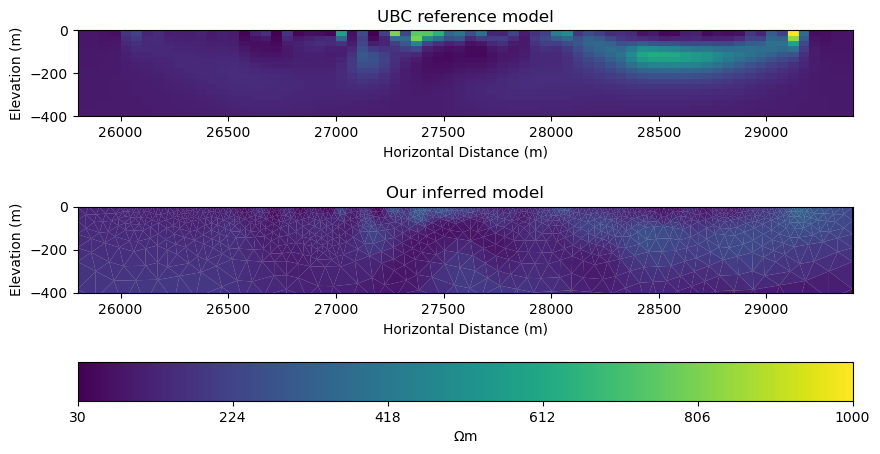

In [25]:
color_range = (30, 1000)

plot_comparison(
    mesh_ubc, 
    model_ubc, 
    "UBC reference model", 
    ert_mgr.paraDomain, 
    model, 
    "Our inferred model",
    color_range
)

### 6.2. SciPy trust-ncg optimizer

In [26]:
#@title Utility Callback Function (hidden, no need to change)

class CallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        if self.x is not None:
            print(f"  model change: {np.linalg.norm(xk - self.x)}")
        print(f"  objective value: {ert_problem.objective(xk)}")
        self.x = xk
        self.i += 1

In [27]:
# CoFI - define InversionOptions
inv_options2 = cofi.InversionOptions()
inv_options2.set_tool("torch.optim")
inv_options2.set_params(algorithm="Rprop", num_iterations=30)

# CoFI - define Inversion and run
inv = cofi.Inversion(ert_problem, inv_options2)
inv_result2 = inv.run()

print(f"\nNumber of objective function evaluations: {inv_result.n_obj_evaluations}")
print(f"Number of gradient function evaluations: {inv_result.n_grad_evaluations}")

Iteration #0, objective value: 16.597655174229914
Iteration #1, objective value: 15.948450064239676
Iteration #2, objective value: 15.24596990275687
Iteration #3, objective value: 14.492950149552165
Iteration #4, objective value: 13.70300924676547
Iteration #5, objective value: 12.91920985303781
Iteration #6, objective value: 12.187443149100195
Iteration #7, objective value: 11.536760237534937
Iteration #8, objective value: 10.99470883317839
Iteration #9, objective value: 10.70095426822779
Iteration #10, objective value: 10.971812062023101
Iteration #11, objective value: 12.06008952690651
Iteration #12, objective value: 14.45066329045611
Iteration #13, objective value: 17.5686952505065
Iteration #14, objective value: 19.926051205492335
Iteration #15, objective value: 23.156315113121657
Iteration #16, objective value: 30.660212700504093
Iteration #17, objective value: 43.20924966086084
Iteration #18, objective value: 47.07097921582876
Iteration #19, objective value: 43.09727122742345
It

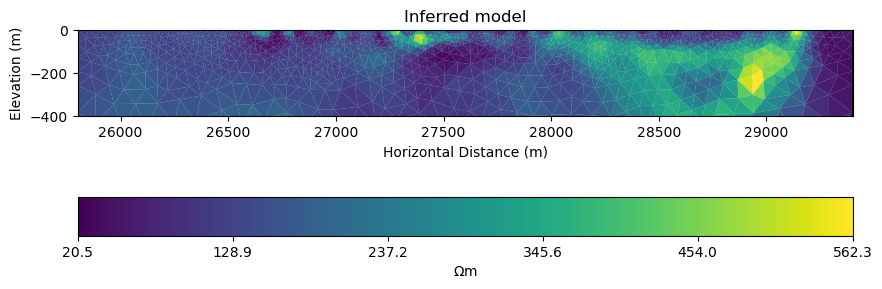

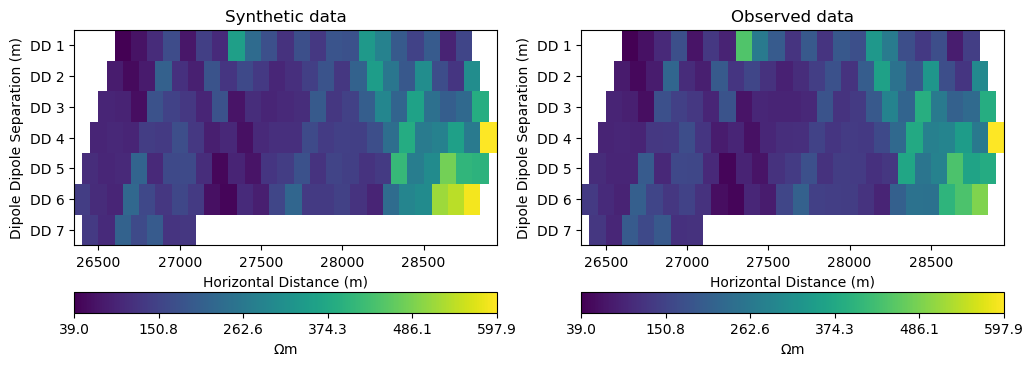

In [28]:
plot_result(inv_result2, ert_mgr)

#### 6.2.1 Compare with UBC results

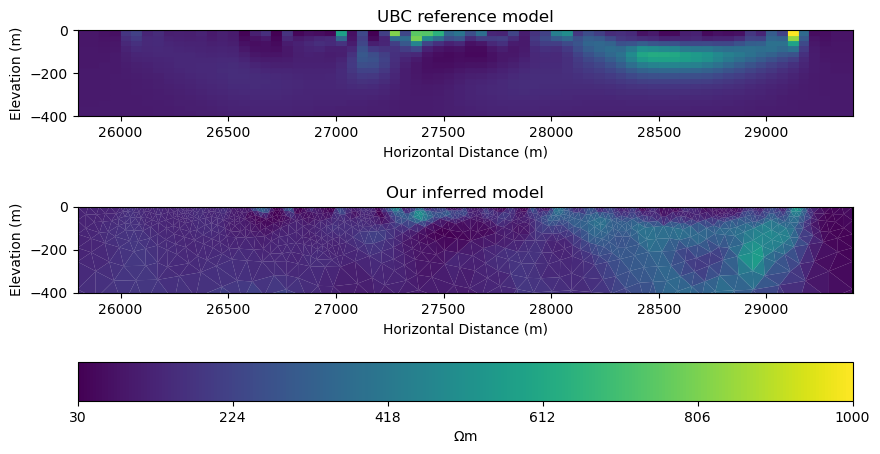

In [29]:
plot_comparison(
    mesh_ubc, 
    model_ubc, 
    "UBC reference model", 
    ert_mgr.paraDomain, 
    np.exp(inv_result2.model), 
    "Our inferred model",
    color_range
)

---
## Watermark

In [30]:
watermark_list = ["cofi", "numpy", "scipy", "pygimli", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.1.2.dev21
numpy 1.21.6
scipy 1.9.1
pygimli 1.2.6
matplotlib 3.5.3
